## Mais Macros ...

Como foi visto na aula anterior, **macros** nos permite rodar funções (e outros macros) em tempo de **compilação**, ao invés do tempo de **execução** que estamos acostumados.

Sendo assim, macros permitem manipular dados antes deles possuírem "significado", ou seja, podemos construir a **sintaxe** da linguagem antes de existir uma **semântica**.

Ou seja, com macros podemos tratar qualquer dado sem se preocupar com seu valor (significado) em dado contexto, nos permitindo trazer novas estruturas a nossa linguagem.

Por exemplo, vamos relembrar como definimos o macro `nlambda`:

In [1]:
(defmacro nlambda (n+args . body) 
  (let ([name (car n+args)]       
        [args (cdr n+args)])      
    `(letrec ([,name (lambda ,args
                       ,@body)])  
       ,name)))

Em apenas 6 linhas fomos capazes de criar uma nova estrutura em nossa linguagem, uma maneira de definir funções lambda recursivas.

### O poder de manipular sintaxe

Com esse poder em mãos somos capazes de abstrair toda estrutura recorrente em nosso código, como utilizar `letrec` para definirmos funções recursivas dentro de um bloco `lambda`.

Em outras palavras, podemos desenvolver toda uma nova linguagem para resolver um problema específico, a isso damos o nome de **EDSLs** (Embedded Domain Specific Language), ou, linguagens de domínio específico embarcadas.
Dizem que um programador LISP não pensa "Como posso resolver esse problema em LISP?" mas sim "Qual a melhor linguagem para resolver esse problema?".

Porém, lembre-se:

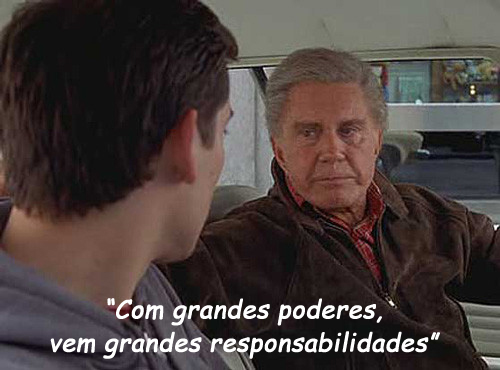

### Mas primeiro

Vamos refrescar um pouco a mente

#### Questão

Em scheme temos o macro `do`, que funciona relativamente parecido a um loop `for` de `C`, sua sintaxe é:

```scheme
(do ((<var> <val> <step*>)
     ...)
    (<cond> ...)
  (<body>))
```

Onde `*` indica que o termo é opcional.

Exemplo:

In [ ]:
(do ((vec (make-vector 5))
     (i 0 (+ i 1)))
    ((= i 5) vec)
  (vector-set! vec i i))

Com base nisso, complete o macro `for-1`, que recebe:

* Uma lista composta por: `var`, `init-val` e `stop-val`;
* Um `corpo`.

Sua sintaxe é:

```scheme
(for-1 (<var> <init-val> <stop-val>) 
  <body>(
```

Por exemplo:

```scheme
(for-1 (x 1 5)
  (display x))

; => 12345
```

In [ ]:
(define-macro (for-1 vvs . body)
  (let ([?   ?????]
        [??  ??????]
        [??? ???????])
    `(do ((? ?? (1+ ?))
          (limit ???))
         ((> ? limit))
       ????)))

#### Questão
O que o código a seguir faz?

```scheme
(for-1 (limit 1 5)
  (display limit))
``` 

### Captura de variaveis livres
O problema que encontramos na definição do macro acima é conhecido como **captura de símbolos livres**, e ele ocorre justamente quando ignoramos a **semântica**, ou seja, nesse caso só consideramos a gramática, o símbolo `limit`, mas ignoramos seu valor (significa) no um contexto.

O nosso código da questão anterior produziria, em tempo de compilação:
```scheme
(do ((limit 1 (1+ limit))
     (limit 5))
    ((> limit limit))
 (display limit))
```

O símbolo `limit` aparece 2 vezes dentro do bloco `do`, que, como `let`, não permite referência a símbolos definidos no mesmo bloco. Obtemos assim um erro:
```
While compiling expression:
Syntax error:
unknown file:346:0: lambda: duplicate identifier in argument list in form (limit limit)
```

### Captura de **símbolos** livres
Imagine o cenário onde queremos definir um macro `captura` que recebe um warning e adciona a uma lista global:

```scheme
(define ws '())

(define-macro (captura warning)
  `(begin (set! ws (append! ws (list ,warning)))
          '()))
```

Agora imagine que queremos escrever uma função que recebe 2 listas e, caso o tamano de alguma delas seja menor que 0, ela dispara um aviso *"tamanho de exemplo menor que 2"*.
```scheme
(define (proporcao vs ws)
  (let ([vn (length vs)]
        [wn (length ws)])
    (if (or (< vn 2) (< wn 2))
        (captura "tamanho de exemplo menor que 2")
        (/ vn wn))))
```

Na expansão do `captura` durante a definição de `proporcao`, teriamos:

```scheme
(define (proporcao vs ws)
  (let ([vn (length vs)]
        [wn (length ws)])
    (if (or (< vn 2) (< wn 2))
        (begin (set! ws (append! ws (list "tamanho de exemplo menor que 2")))
               '())
        (/ vn wn))))
```

#### Questão
Qual o problema na definição da função `proporcao`?

#### Questão
Qual o valor de `lst` após o programa a seguir ser executado?
```scheme
(define (lst '(1)))

(proporcao '() lst)
```

### Quando ocorre uma captura?

Antes de discutirmos quando um macro pode capturar uma váriavel ou símbolo, é importante definirmos alguns conceitos:

##### *Livre*: Um símbolo é dito livre quando ele está presente em uma expressão sem ser vinculado a nenhum valor no corpo.

#### Questão
Quais símbolos são  *livres*  nas definições a seguir?

```scheme
(define (soma-x z)
  (+ z x))

(defmacro (val? z)
  `(when (= val ,z)
         ,z)))
```

##### *Esqueleto*: O esqueleto de uma expansão de macro é toda a expansão, exceto toda aparição dos argumentos passados para o macro.

#### Questão
Qual o esqueleto da chamada a seguir?

```scheme
(define-macro (foo x y)
  `(/ (+ ,x 1) ,y))

(foo (- 5 2) 6)
```

##### *Capturável*: Um símbolo é capturável se, durante a expansão de um macro ele:
1) ocorre livre no esqueleto;
2) é vinculado por alguma parte do esqueleto no qual os argumentos passados para o macro são ou vinculados ou computados.

#### Questão
Em quais macros definidos a seguir `x` e capturável?
```scheme
(define-macro (m1)
  '(+ x 1))

(define-macro (m2 var)
  `(let ([x ...]
         [,var ...])
     ...))

(define-macro (m3 var)
  `(let ([x ...])
     (let ([,var ...])
       ...)))

(define-macro (m4 var)
  `(let ([,var ...])
     (let ([x ...])
       ...)))

(define-macro (m5 var)
  `(begin (let ([x 1])
            (display x))
          (let ([,var 1])
            (display ,var))))

(define-macro (m6 . body)
  `(let ([x ...])
     ,@body))

(define-macro (m7 expr)
  `(let [(x ,expr])
     (cons x 1))))

(define-macro (m8 var . body)
  `(let ([,var ...])
     ,@body))

(define-macro (pathological . body)
  (let* ([syms (filter symbol? 
                       (flatten body))]
         [var (list-ref (random (length syms)) 
                        syms)])
    `(let ((,var 99))
       ,@body)))
```

### Símbolos aleatórios
O Problema da captura é tão comum que grande parte dos LISPs possuem uma função chamda `gensym`, que recebe 0 ou 1 string e retorna um símbolo aleatório, caso uma string `str` seja passada como parâmetro, ela retorna *str<aleatório>*. Veja: 

In [ ]:
(gensym)

In [ ]:
(gensym "SouUmaStringTodaJunta")

In [ ]:
(gensym "Sou uma string toda espaçada")

A função `gensym` é utilizada justamente como ferramente para evitar a captura de um simbolo, na verdade, ela garante que o símbolo gerado nunca ocorre, se não de forma explicita, no código, armazenando-o em uma namespace diferente.

Por exemplo, podemos redefinir `for-1` utilizando `gensym`:

In [ ]:
(define-macro (for-1 vvs . body)
  (let ([var    (car vvs)]
        [start  (cadr vvs)]
        [stop   (caddr vvs)]
        [glimit (gensym "limit")])
    (format #t "GLIMIT: ~A\n" glimit)
    `(do ((,var ,start (1+ ,var))
          (,glimit ,stop))
         ((> ,var ,glimit))
       ,@body)))

In [ ]:
(for-1 (limit 1 5)
  (display limit))

Como podemos perceber, em cada execução o simbolo gerado para a variável `glimit` é diferente.

#### Questão
Por que não podemos definir `for-1` como a seguir? 

```scheme
(define-macro (for-1 vvs . body)
  (let ([var   (car vvs)]
         start (cadr vvs)]
         stop  (caddr vvs)])
    `(do ((,var ,start (1+ ,var)))
         ((> ,var ,stop))
       ,@body))
```


```scheme
(define-macro (for vvs . body)
  (let ([var    (car vvs)]
        [start  (cadr vvs)]
        [stop   (caddr vvs)])
        [glimit (gensym "limit")])
    `(do ((,glimit ,stop)
          (,var ,start (1+ ,var)))
         ((> ,var ,glimit))
       ,@body)))
```

### Captura Proposital
As vezes queremos que um símbolo tenha um significado especial em nosso macro, por exemplo, o `else` em um cond, por conta disso, capturamos ele propositalmente, conhecendo as consequências, imaginando que o usuário nunca irá usar tal símbolo no contexto da chamada do macro.

Um exemplo clássico de captura proposital de símbolos são os chamados **macros anafóricos**.

### O que é uma anáfora?
Em linguística, anáfora é uma expressão que se refere a algo que ocorreu na mesma frase ou texto.
Por exemplo: "O sistema de macros do LISP é muito robusto. **Ele** permite a manipulação da grámatica da linguagem."

### Como um macro pode ser anafórico?
Ao manipularmos a estrutura da linguagens, podemos capturar **blocos** de código já definidos, não só isso, como **LISP** permite o uso de funções e macros dentro de macros, podemos guardar esses blocos em uma variável e, além disso, alterar o valor dessa variável em tempo de **compilação**.

Vejamos o exemplo do `if` anafórico `aif`:

In [ ]:
(define-macro (aif test then else)
  `(let ([it ,test])
     (if it ,then ,else)))

In [ ]:
(define (not-zero x)
  (if (zero? x)
      #f
      x))

(aif (not-zero (+ 1 (car '(2 3))))
     (+ it it)
     it)

In [ ]:
(aif (not-zero (- 4 (caddr '(5 6 4 7 8))))
     (- 2 it)
     (not it))

### Questão
O `aif` só nos permite tirar proveito de sua anáfora em 2 casos (*then* e *else*).

Complete o `cond` anafórico `acond`, para podermos utilizar `it` em múltiplas cláusulas: 

In [ ]:
(define-macro (acond . clauses)
  (when (not (null? ?))
    (let ([cl1   (car ?)]
          [gcond ??])
      `(let ([,gcond ,(car ???)])
         (if ????
             (let ([????? ????])
               ,@(cdr ???))
             (?????? ,@(cdr ?)))))))

### Questão
Qual a utilidade do `gcond` no macro `acond`? 
Ou melhor, por que a definição a seguir estaria incorreta?

```scheme
(defmacro acond (&rest clauses)
  (when (not (null? ?))
    (let ((cl1 (car ?)))
      `(let ((it ,(car ???)))
         (if it
             (begin ,@(cdr ???))
             (?????? ,@(cdr ?)))))))
```

### Questão
Acrescente a cláusula `else` como em `cond` em sua versão anafórica `acond`:

In [ ]:
(define-macro (acond . clauses)
  ...)

### Questao
Utilizando `aif` defina a versão anafórica do `and`:

In [ ]:
(define-macro (aand . args)
  ...)